# Creating Permanent Tables and Access-Controlled Views in BigQuery

GSP410

https://www.cloudskillsboost.google/focuses/3690?parent=catalog&qlcampaign=1p-EDUCR-SG-2021-MAJULAHGCP-2-25

## Overview
BigQuery is Google's fully managed, NoOps, low cost analytics database. With BigQuery you can query terabytes and terabytes of data without having any infrastructure to manage or needing a database administrator. BigQuery uses SQL and can take advantage of the pay-as-you-go model. BigQuery allows you to focus on analyzing data to find meaningful insights.

The dataset you'll use is a****n ecommerce dataset that has millions of Google Analytics records for the Google Merchandise Store loaded into BigQuery. You have a copy of that dataset for this lab and will explore the available fields and row for insights.

In this lab you will learn how to create new permanent reporting tables and logical reviews from an existing ecommerce dataset.

# Troubleshooting CREATE TABLE statements
Your data analyst team has provided you with the below query statements designed to create a permanent table in your new ecommerce dataset. Unfortunately they're not working properly.

Diagnose why each of the queries is broken and offer a solution.

Rules for creating tables with SQL in BigQuery

Read through these create table rules which you will use as your guide when fixing broken queries:

1. Either the specified column list or inferred columns from a query_statement (or both) must be present.

2. When both the column list and the as query_statement clause are present, BigQuery ignores the names in the as query_statement clause and matches the columns with the column list by position.

3. When the as query_statement clause is present and the column list is absent, BigQuery determines the column names and types from the as query_statement clause.

4. Column names must be specified either through the column list or as query_statement clause.

5. Duplicate column names are not allowed.

### Query 1: Columns, Columns, Columns

`Error: CREATE TABLE has columns with duplicate name fullVisitorId at [7:2]`

Which one of the create table rules is violated in the above query?

Rule #5 duplicate column names are not allowed.



In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT fullVisitorId, * FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

### Query 2: Columns revisited

`Error: The number of columns in the column definition list does not match the number of columns produced by the query at [5:1]`

Which one of the create table rules is violated in the above query?

Rule #2 the query statement names are ignored.

Note: You cannot specify a schema of fields for a new table which does not match the number of columns returned by the query statement. In the above a two column schema was specified with `fullVisitorId` and `channelGrouping` but in the query statement all columns returned (*) was specified.

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
#schema
(
  fullVisitorId STRING OPTIONS(description="Unique visitor ID"),
  channelGrouping STRING OPTIONS(description="Channel e.g. Direct, Organic, Referral...")
)
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT * FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

### Query 3: It's Valid! Or is it?

`Valid: This query will process 1.1 GiB when run.`

Although the number of columns match between the schema definition and the query statement, the actual column retrieved from the query statement for the channelGrouping column is not channelGrouping but rather the visitors city.

Remember Rule #2: when both the column list and the `as` query_statement clause are present, BigQuery ignores the names in the `as` query_statement clause and matches the columns with the column list by position.

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
#schema
(
  fullVisitorId STRING OPTIONS(description="Unique visitor ID"),
  channelGrouping STRING OPTIONS(description="Channel e.g. Direct, Organic, Referral...")
)
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT fullVisitorId, city FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

### Query 4: The gatekeeper

`Valid: This query will process 907.52 MiB when run.`

The query will fail. You need to specify `totalTransactionRevenue` as nullable (NULL) since not all visitors will buy

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
#schema
(
  fullVisitorId STRING NOT NULL OPTIONS(description="Unique visitor ID"),
  channelGrouping STRING NOT NULL OPTIONS(description="Channel e.g. Direct, Organic, Referral..."),
  totalTransactionRevenue INT64 NOT NULL OPTIONS(description="Revenue * 10^6 for the transaction")
)
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT fullVisitorId, channelGrouping, totalTransactionRevenue FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

### Query 5: Working as intended

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.all_sessions_raw_20170801
#schema
(
  fullVisitorId STRING NOT NULL OPTIONS(description="Unique visitor ID"),
  channelGrouping STRING NOT NULL OPTIONS(description="Channel e.g. Direct, Organic, Referral..."),
  totalTransactionRevenue INT64 OPTIONS(description="Revenue * 10^6 for the transaction")
)
 OPTIONS(
   description="Raw data from analyst team into our dataset for 08/01/2017"
 ) AS
 SELECT fullVisitorId, channelGrouping, totalTransactionRevenue FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'  #56,989 records
;

Browse your `ecommerce` dataset panel to confirm the `all_sessions_raw_(1)` is present.

Why is the full table name not showing?

Answer: The table suffix 20170801 is automatically partitioned by day. If we created more tables for other days, the `all_sessions_raw_(N)` would increment by N distinct days of data. There is another lab that explores different ways of partitioning your data tables.

What are the key benefits to formally defining a table schema as opposed to relying on your query statement for the field names and data types?

- You may not have any existing data yet to populate the table with inferred field names in a query statement
- You can specify field descriptions.
- You can specify REQUIRED fields (NOT NULL)
- You can specify expected data types (rather than rely on inference)



# Goal: In the Query Editor, create a new permanent table that stores all the transactions with revenue for August 1st, 2017.

Create a new table in your `ecommerce` dataset titled `revenue_transactions_20170801`. Replace the table if it already exists.

Source your raw data from the `data-to-insights.ecommerce.all_sessions_raw` table.

Divide the revenue field by 1,000,000 and store it as a `FLOAT64` instead of an INTEGER.

Only include transactions with revenue in your final table (hint: use a `WHERE` clause).

Only include transactions on 20170801.

Include these fields:
- `fullVisitorId` as a REQUIRED string field.
- `visitId` as a REQUIRED string field (hint: you will need to type convert).
- `channelGrouping` as a REQUIRED string field.
- `totalTransactionRevenue` as a FLOAT64 field.

Add short descriptions for the above four fields by referring to the schema.

Be sure to deduplicate records that have the same `fullVisitorId` and `visitId` (hint: use `DISTINCT`).

In [ ]:
#standardSQL
# copy one day of ecommerce data to explore
CREATE OR REPLACE TABLE ecommerce.revenue_transactions_20170801
#schema
(
  fullVisitorId STRING NOT NULL OPTIONS(description="Unique visitor ID"),
  visitId STRING NOT NULL OPTIONS(description="ID of the session, not unique across all users"),
  channelGrouping STRING NOT NULL OPTIONS(description="Channel e.g. Direct, Organic, Referral..."),
  totalTransactionRevenue FLOAT64 NOT NULL OPTIONS(description="Revenue for the transaction")
)
 OPTIONS(
   description="Revenue transactions for 08/01/2017"
 ) AS
 SELECT DISTINCT
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE date = '20170801'
      AND totalTransactionRevenue IS NOT NULL #XX transactions
;

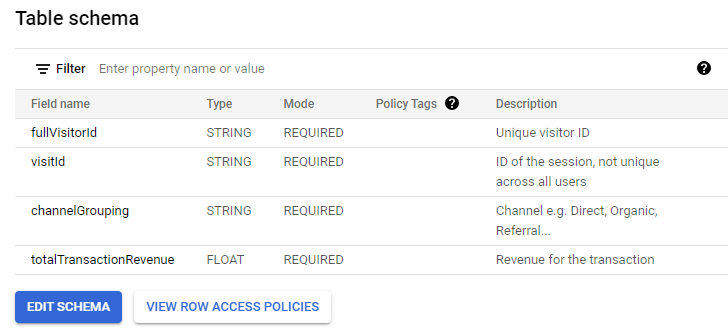

### Handling upstream source data updates

What if the upstream raw data table `data-to-insights.ecommerce.all_sessions_raw` was updated with new transactions for 20170801? Would those be reflected in your `revenue_transactions_20170801` table?

No. Once a permanent table is created it only has the data that was originally ingested into it. Any changes to upstream data tables will not be reflected in downstream tables unless those new records are added.

### What are ways to overcome stale data?
There are two ways to overcome stale data in reporting tables:

1. Periodically refresh the permanent tables by re-running queries that insert in new records. This can be done with BigQuery scheduled queries or with a Cloud Dataprep / Cloud Dataflow workflow.

2. Use logical views to re-run a stored query each time the view is selected.

In the remainder of this lab you will focus on how to create logical views.

# Creating views

Views are saved queries that are run each time the view is called. In BigQuery, views are logical and not materialized. Only the query is stored as part of the view -- not the underlying data.

To save time and enable better organization and collaboration, you can save your common reporting queries as views as demonstrated below.

Tip: It is often difficult to know whether or not you are SELECTing from a Table or a View by just looking at the name. A simple convention is to prefix the view name with `vw_` or add a suffix like `_vw` or `_view`.

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_latest_transactions
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE totalTransactionRevenue IS NOT NULL
 ORDER BY date DESC # latest transactions
 LIMIT 100
;

You can also give your view a description and labels using `OPTIONS`. 

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_latest_transactions
OPTIONS(
  description="latest 100 ecommerce transactions",
  labels=[('report_type','operational')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE totalTransactionRevenue IS NOT NULL
 ORDER BY date DESC # latest transactions
 LIMIT 100
;

Now run the below query to create a new view.

`Error: Already Exists: Table project-name:ecommerce.vw_latest_transactions`

You'll likely receive an error if you have already created the view before. Can you see why?

Answer: The view creation statement was updated to simply be `CREATE` instead of `CREATE OR REPLACE` which will not let you overwrite existing tables or views if they already exist. A third option, `CREATE VIEW IF NOT EXISTS`, will allow you to only create if the table or view doesn't exist or else it will skip the creation and not error.

In [ ]:
#standardSQL
# top 50 latest transactions
CREATE VIEW ecommerce.vw_latest_transactions # CREATE
OPTIONS(
  description="latest 50 ecommerce transactions",
  labels=[('report_type','operational')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  CAST(visitId AS STRING) AS visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE totalTransactionRevenue IS NOT NULL
 ORDER BY date DESC # latest transactions
 LIMIT 50
;

When would you use `CREATE VIEW IF NOT EXISTS` as opposed to `CREATE VIEW`?

When you want to create a view if it does not already exist but avoid throwing a query error if it does exist and simply skip the creation.


# Scenario: Your anti-fraud team has asked you to create a report that lists the 10 most recent transactions that have an order amount of 1,000 or more for them to review manually.

# Task: Create a new view that returns all the most recent 10 transactions with revenue greater than 1,000 on or after January 1st, 2017.

Create a new view in your ecommerce dataset titled "vw_large_transactions". Replace the view if it already exists.

Give the view a description "large transactions for review".

Give the view a label [("org_unit", "loss_prevention")].

Source your raw data from the `data-to-insights.ecommerce.all_sessions_raw` table.

Divide the revenue field by 1,000,000.

Only include transactions with revenue greater than or equal to 1,000

Only include transactions on or after 20170101 ordered by most recent first.

Only include currencyCode = 'USD'.

Return these fields:
- date
- fullVisitorId
- visitId
- channelGrouping
- totalTransactionRevenue AS revenue
- currencyCode
- v2ProductName

Be sure to deduplicate records (hint: use `DISTINCT`).

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_large_transactions
OPTIONS(
  description="large transactions for review",
  labels=[('org_unit','loss_prevention')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS revenue,
  currencyCode
  #v2ProductName
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
 ORDER BY date DESC # latest transactions
 LIMIT 10
;

Note that you need to repeat the division in the `WHERE` clause because you cannot use aliased field names as filters.

# Scenario: Your anti-fraud department is grateful for the query and they are monitoring it daily for suspicious orders. They have now asked you to include a sample of the products that are part of each order along with the results you returned previously.

Using the BigQuery string aggregation function `STRING_AGG` and the `v2ProductName` field, modify your previous query to return 10 of the product names in each order, listed alphabetically.

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_large_transactions
OPTIONS(
  description="large transactions for review",
  labels=[('org_unit','loss_prevention')]
)
AS
SELECT DISTINCT
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue,
  currencyCode,
  STRING_AGG(DISTINCT v2ProductName ORDER BY v2ProductName LIMIT 10) AS products_ordered
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
 GROUP BY 1,2,3,4,5,6
  ORDER BY date DESC # latest transactions
  LIMIT 10

Note the two additions here to aggregate the list of products in each order with `STRING_AGG()` and, since you're performing an aggregation, the necessary `GROUP BY` is added for the other fields.

# Using SESSION_USER() in views for limiting data access

## Scenario: Your data team lead has asked you to come up with a way to limit who in your organization can see the data returned by the view you just created. Order information is especially sensitive and needs to be shared only with users that have a need to see such information.

Task: Modify the view you created earlier to only allow logged in users with a qwiklabs.net session domain to be able to see the data in the underlying view. (Note: You will be creating specific user group allowlists in a later lab on access; for now you are validating based on the session user's domain).

To view your own session login information, run the below query that uses `SESSION_USER()`:

In [ ]:
#standardSQL
SELECT
  SESSION_USER() AS viewer_ldap;

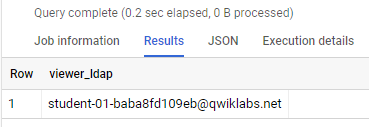

Add an additional filter to only allow users in the qwiklabs.net domain to see view results.

In [ ]:
#standardSQL
SELECT DISTINCT
  SESSION_USER() AS viewer_ldap,
  REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') AS domain,
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue,
  currencyCode,
  STRING_AGG(DISTINCT v2ProductName ORDER BY v2ProductName LIMIT 10) AS products_ordered
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
  AND REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') IN ('qwiklabs.net')
 GROUP BY 1,2,3,4,5,6,7,8
  ORDER BY date DESC # latest transactions
  LIMIT 10

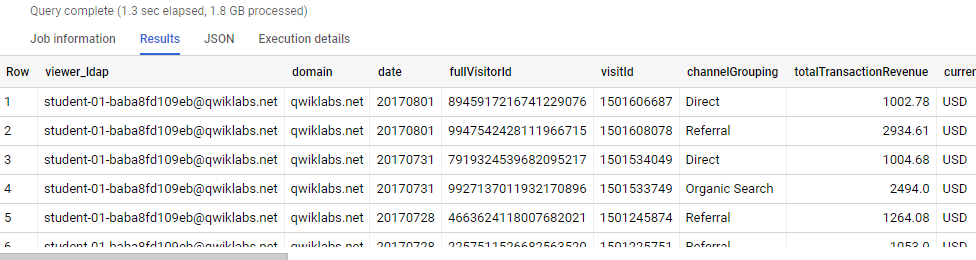

Re-create and replace the `vw_large_transactions` view with the new query above. As an additional `OPTIONS` parameter, add an `expiration_timestamp` for the entire view to be 90 days from now.

Note: the `expiration_timestamp` option can also be applied to permanent tables.

In [ ]:
#standardSQL
CREATE OR REPLACE VIEW ecommerce.vw_large_transactions
OPTIONS(
  description="large transactions for review",
  labels=[('org_unit','loss_prevention')],
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 90 DAY)
)
AS
#standardSQL
SELECT DISTINCT
  SESSION_USER() AS viewer_ldap,
  REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') AS domain,
  date,
  fullVisitorId,
  visitId,
  channelGrouping,
  totalTransactionRevenue / 1000000 AS totalTransactionRevenue,
  currencyCode,
  STRING_AGG(DISTINCT v2ProductName ORDER BY v2ProductName LIMIT 10) AS products_ordered
 FROM `data-to-insights.ecommerce.all_sessions_raw`
 WHERE
  (totalTransactionRevenue / 1000000) > 1000
  AND currencyCode = 'USD'
  AND REGEXP_EXTRACT(SESSION_USER(), r'@(.+)') IN ('qwiklabs.net')
 GROUP BY 1,2,3,4,5,6,7,8
  ORDER BY date DESC # latest transactions
  LIMIT 10;

Confirm with the below `SELECT` statement you can see the data returned in the view (given your domain access) and the expiration timestamp in the view details.